In [1]:
import os
from dotenv import load_dotenv
import json
import random
import matplotlib.pyplot as plt
import numpy as np
import asyncio
import pandas as pd

from benchmarklib import BenchmarkDatabase, _BenchmarkDatabase
from rbf import RandomBooleanFunctionTrial, RandomBooleanFunction, _RandomBooleanFunction, _RandomBooleanFunctionTrial
from benchmarklib.compilers import CompileType, XAGCompiler, QCFCompiler

from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
service = QiskitRuntimeService()

In [3]:
# run this cell to load the job results for all trials that are waiting pending job results
benchmark_db = BenchmarkDatabase("rbf.db", RandomBooleanFunction, RandomBooleanFunctionTrial)
#benchmark_db = _BenchmarkDatabase("_rbf.db", _RandomBooleanFunction, _RandomBooleanFunctionTrial)
#await benchmark_db.update_all_pending_results(service, batch_size=1)

In [4]:
from benchmarklib.analysis import analyze_success_rates
from benchmarklib.compilers import TruthTableCompiler

In [5]:
def get_probability_data(db, compiler, function_success_threshold, num_vars_iter = range(2, 21), complexity_iter = range(1, 21)):
    num_vars_data = []
    complexity_data = []
    probability_data = []
    mean_success_data = []

    for num_vars in num_vars_iter:
        for complexity in complexity_iter:
            print(f"(num_vars, complexity) = ({num_vars}, {complexity})")
            mean_success_rate = 0.0
            successful_function_count = 0
            function_count = 0
            no_data = True
            problem_instances = db.find_problem_instances(num_vars=num_vars, complexity=complexity)
            #problem_instances = db.find_problem_instances(size_filters={"num_vars": num_vars, "complexity": complexity})
            trials_by_function = {instance.id: db.find_trials(instance_id=instance.id, compiler_name=compiler.name) for instance in problem_instances}
            #trials_by_function = trials.get_per_statement(num_vars=num_vars, complexity=complexity)
            for function in trials_by_function.keys():
                # skip functions with no trials for this compiler
                if len(trials_by_function[function]) == 0:
                    continue
                function_count += 1
                no_data = False
                
                s = 0.0
                for trial in trials_by_function[function]:
                    s += trial.calculate_success_rate()
                    
                if s / len(trials_by_function[function]) > function_success_threshold:
                    successful_function_count += 1
                mean_success_rate += s / len(trials_by_function[function])

            if no_data:
                 print(f"Warning: no results for {num_vars} variables, complexity {complexity}; skipping")
                 continue
            
            num_vars_data.append(num_vars)
            complexity_data.append(complexity)
            probability_data.append(successful_function_count / function_count if function_count > 0 else 0)
            mean_success_data.append(mean_success_rate / function_count if function_count > 0 else 0)
    
    return num_vars_data, complexity_data, probability_data

def plot_probability_data(num_vars_data, complexity_data, probability_data, title, filepath=None):
    
    df = pd.DataFrame({
        'num_vars': num_vars_data,
        'complexity': complexity_data,
        'prob': probability_data
    })
    grid = df.pivot(index='complexity', columns='num_vars', values='prob')
    grid = grid.sort_index(ascending=True)

    plt.figure(figsize=(12, 10))
    plt.pcolormesh(
        grid.columns, grid.index, grid.values,
        cmap='RdYlGn', shading='auto'
    )

    plt.xticks(np.arange(min(num_vars_data), max(num_vars_data) + 1, 1))
    plt.yticks(np.arange(min(complexity_data), max(complexity_data) + 1, 1))

    plt.xlabel('Variables Count')
    plt.ylabel('Complexity')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(f'Mean Success Rate', rotation=270, labelpad=15)
    if filepath is not None:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

def plot_probability_data_side_by_side(num_vars_data, complexity_data, probability_data1, probability_data2, title1, title2, filepath=None):
    df1 = pd.DataFrame({
        'num_vars': num_vars_data,
        'complexity': complexity_data,
        'prob': probability_data1
    })
    grid1 = df1.pivot(index='complexity', columns='num_vars', values='prob')
    grid1 = grid1.sort_index(ascending=True)

    df2 = pd.DataFrame({
        'num_vars': num_vars_data,
        'complexity': complexity_data,
        'prob': probability_data2
    })
    grid2 = df2.pivot(index='complexity', columns='num_vars', values='prob')
    grid2 = grid2.sort_index(ascending=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plot1 = axes[0].pcolormesh(
        grid1.columns, grid1.index, grid1.values,
        cmap='RdYlGn', shading='auto'
    )
    axes[0].set_xticks(np.arange(min(num_vars_data), max(num_vars_data) + 1, 1))
    axes[0].set_yticks(np.arange(min(complexity_data), max(complexity_data) + 1, 1))
    axes[0].set_xlabel('Variables Count')
    axes[0].set_ylabel('Complexity')
    axes[0].set_title(title1)

    plot2 = axes[1].pcolormesh(
        grid2.columns, grid2.index, grid2.values,
        cmap='RdYlGn', shading='auto'
    )
    axes[1].set_xticks(np.arange(min(num_vars_data), max(num_vars_data) + 1, 1))
    axes[1].set_yticks(np.arange(min(complexity_data), max(complexity_data) + 1, 1))
    axes[1].set_xlabel('Variables Count')
    axes[1].set_ylabel('Complexity')
    axes[1].set_title(title2)

    cbar = fig.colorbar(plot1, ax=axes.ravel().tolist(), shrink=0.95)
    cbar.set_label(f'Mean Success Rate', rotation=270, labelpad=15)
    if filepath is not None:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()


def plot_probability_difference(num_vars_data, complexity_data, probability_data1, probability_data2, title, filepath=None):
    difference_data = [p1 - p2 for p1, p2 in zip(probability_data1, probability_data2)]
    df = pd.DataFrame({
        'num_vars': num_vars_data,
        'complexity': complexity_data,
        'diff': difference_data
    })
    grid = df.pivot(index='complexity', columns='num_vars', values='diff')
    grid = grid.sort_index(ascending=True)
    plt.figure(figsize=(12, 10))
    plt.pcolormesh(
        grid.columns, grid.index, grid.values,
        cmap='RdBu_r', shading='auto', vmin=-0.2, vmax=0.2
    )
    plt.xticks(np.arange(min(num_vars_data), max(num_vars_data) + 1, 1))
    plt.yticks(np.arange(min(complexity_data), max(complexity_data) + 1, 1))

    plt.xlabel('Variables Count')
    plt.ylabel('Complexity')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(f'Difference in Success Rate', rotation=270, labelpad=15)
    if filepath is not None:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
# calculate performance data
benchmark_db = BenchmarkDatabase("rbf.db", RandomBooleanFunction, RandomBooleanFunctionTrial)
num_vars_range = range(2, 21)
complexity_range = range(1, 21)
num_vars_data, complexity_data, probability_data_qcf = get_probability_data(benchmark_db, compiler=QCFCompiler(), function_success_threshold=0.5, num_vars_iter=num_vars_range, complexity_iter=complexity_range)
num_vars_data, complexity_data, probability_data_xag = get_probability_data(benchmark_db, compiler=XAGCompiler(), function_success_threshold=0.5, num_vars_iter=num_vars_range, complexity_iter=complexity_range)

(num_vars, complexity) = (2, 1)
(num_vars, complexity) = (2, 2)
(num_vars, complexity) = (2, 3)
(num_vars, complexity) = (2, 4)
(num_vars, complexity) = (2, 5)
(num_vars, complexity) = (2, 6)
(num_vars, complexity) = (2, 7)
(num_vars, complexity) = (2, 8)
(num_vars, complexity) = (2, 9)
(num_vars, complexity) = (2, 10)
(num_vars, complexity) = (2, 11)
(num_vars, complexity) = (2, 12)
(num_vars, complexity) = (2, 13)
(num_vars, complexity) = (2, 14)
(num_vars, complexity) = (2, 15)
(num_vars, complexity) = (2, 16)
(num_vars, complexity) = (2, 17)
(num_vars, complexity) = (2, 18)
(num_vars, complexity) = (2, 19)
(num_vars, complexity) = (2, 20)
(num_vars, complexity) = (3, 1)
(num_vars, complexity) = (3, 2)
(num_vars, complexity) = (3, 3)
(num_vars, complexity) = (3, 4)
(num_vars, complexity) = (3, 5)
(num_vars, complexity) = (3, 6)
(num_vars, complexity) = (3, 7)
(num_vars, complexity) = (3, 8)
(num_vars, complexity) = (3, 9)
(num_vars, complexity) = (3, 10)
(num_vars, complexity) = (3,

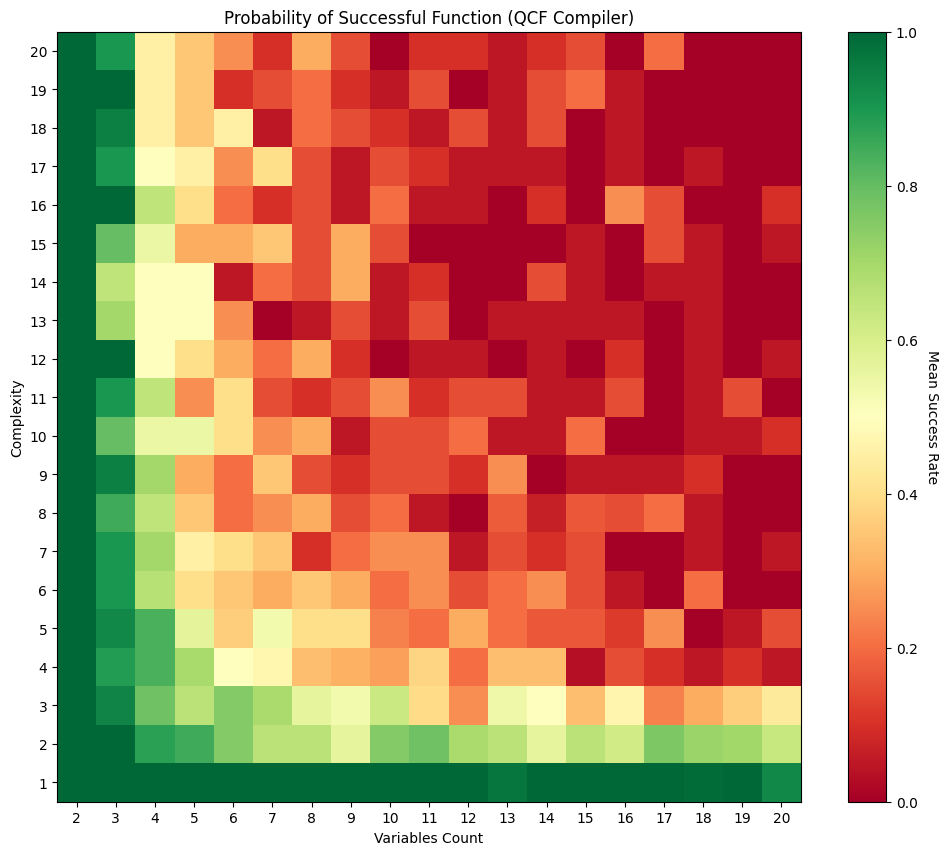

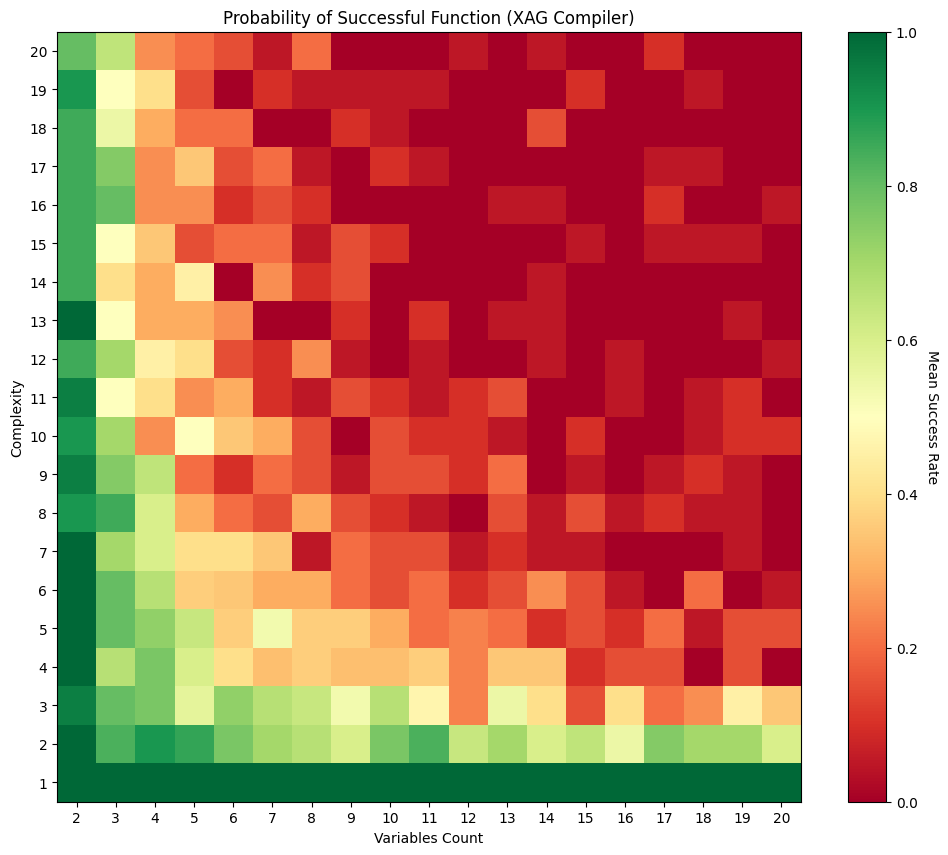

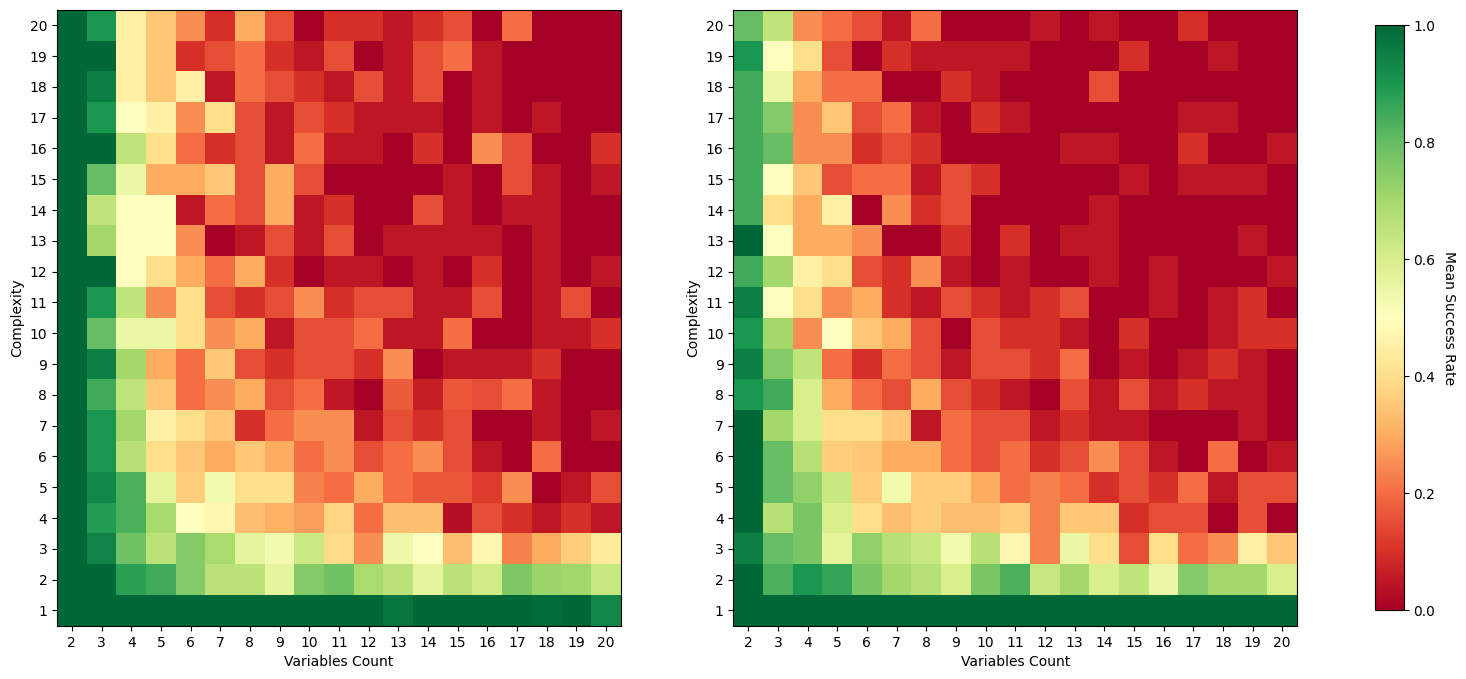

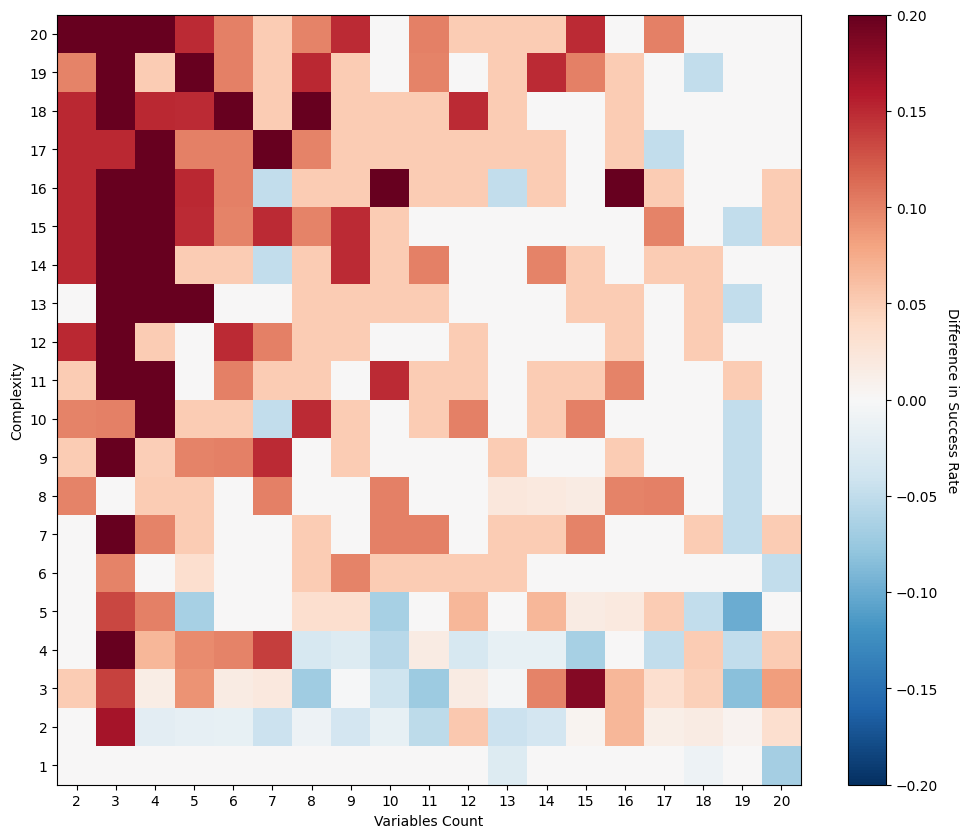

In [7]:
# plot data
plot_probability_data(num_vars_data, complexity_data, probability_data_qcf, title="Probability of Successful Function (QCF Compiler)", filepath="qcf_compiler_success_probability.png")
plot_probability_data(num_vars_data, complexity_data, probability_data_xag, title="Probability of Successful Function (XAG Compiler)", filepath="xag_compiler_success_probability.png")
plot_probability_data_side_by_side(num_vars_data, complexity_data, probability_data_qcf, probability_data_xag, title1="", title2="", filepath="RBF_compiler_success_probability_comparison.png")
plot_probability_difference(num_vars_data, complexity_data, probability_data_qcf, probability_data_xag, title="", filepath="RBF_compiler_success_probability_difference.png")

In [ ]:
# plot data
plot_probability_data(num_vars_data, complexity_data, probability_data_qcf, title="Probability of Successful Function (QCF Compiler)", filepath="qcf_compiler_success_probability.png")
plot_probability_data(num_vars_data, complexity_data, probability_data_xag, title="Probability of Successful Function (XAG Compiler)", filepath="xag_compiler_success_probability.png")
plot_probability_data_side_by_side(num_vars_data, complexity_data, probability_data_qcf, probability_data_xag, title1="QCF Compiler", title2="XAG Compiler", filepath="compiler_success_probability_comparison.png")
plot_probability_difference(num_vars_data, complexity_data, probability_data_qcf, probability_data_xag, title="Difference in Probability of Success (QCF - XAG)", filepath="compiler_success_probability_difference.png")


In [ ]:
def plot_counts_data(num_vars_data, complexity_data, probability_data, title, threshold=None, filepath=None):
    if threshold is not None:
        colors = ['green' if p > threshold else 'red' for p in probability_data]
    else:
        colors = probability_data

    plt.figure(figsize=(10, 10))
    plt.scatter(num_vars_data, complexity_data, c=probability_data, cmap='RdYlGn', edgecolors='black', alpha=0.75, s=250)
    plt.xticks(np.arange(min(num_vars_data), max(num_vars_data) + 1, 1))
    plt.yticks(np.arange(min(complexity_data), max(complexity_data) + 1, 1))

    plt.xlabel('Variables Count')
    plt.ylabel('Complexity')
    plt.title(title)
    cbar = plt.colorbar()
    if filepath is not None:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
#if compiler.name == CompileType.CLASSICAL_FUNCTION:
#    title = "Qiskit Classical Function on Random Boolean Functions"
#elif compiler.name == CompileType.XAG:
#    title = "Tweedledum XAG on Random Boolean Functions"
#plot_probability_data(num_vars_data_exact, complexity_data_exact, probability_data_exact, title, threshold=0.5, filepath=f'exact_match_rate_{compiler.name}.png')

In [ ]:
# plot the number of functions we have data for, for each number of variables and complexity
num_vars_data = []
complexity_data = []
function_count_data = []

for num_vars in range(2, 33):
        for complexity in range(1, 22):
            with trials._connect() as conn:
                cursor = conn.cursor()
                cursor.execute("SELECT COUNT(DISTINCT statement) FROM trials WHERE num_vars = ? AND complexity = ? AND NOT counts = ''", (num_vars, complexity))
                count = cursor.fetchone()[0]
                num_vars_data.append(num_vars)
                complexity_data.append(complexity)
                function_count_data.append(count)
            print(f"(num_vars, complexity) = ({num_vars}, {complexity})")

In [ ]:
for i in range(len(function_count_data)):
    if function_count_data[i] > 30:
        function_count_data[i] = 30

In [ ]:
plot_counts_data(num_vars_data, complexity_data, function_count_data, 'Number of functions with data', filepath=f'function_count_{compiler.name}.png')

In [ ]:
def get_stddev_data(db, use_hamming=False):
    # compute standard deviations of exact match rate across different trials for the same function
    
    num_vars_data = []
    complexity_data = []
    all_stddev_data = {}

    for num_vars in range(2, 33): # 2 - 32
        for complexity in range(1, 22): # 1 - 21
            print(f"(num_vars, complexity) = ({num_vars}, {complexity})")
    
            stddev_data = []
            no_data = True
            problem_instances = db.find_problem_instances(size_filters={'num_vars': num_vars, 'complexity': complexity})
            trials_by_function = {instance.instance_id: db.find_trials(instance_id=instance.instance_id, compiler_name=compiler.name) for instance in problem_instances}
            #trials_by_function = trials.get_per_statement(num_vars=num_vars, complexity=complexity)

            for function in trials_by_function.keys():
                # skip functions with no trials for this compiler
                if len(trials_by_function[function]) == 0:
                    continue

                no_data = False
                
                accuracy_rates = []
                for trial in trials_by_function[function]:
                    if use_hamming:
                        accuracy_rates.append(1-trial.mean_hamming_distance)
                    else:
                        accuracy_rates.append(trial.result_qubit_success_rate)

                stddev_data.append(np.std(accuracy_rates))
                    
            if no_data:
                 print(f"Warning: no results for {num_vars} variables, complexity {complexity}; skipping")
                 continue
            
            num_vars_data.append(num_vars)
            complexity_data.append(complexity)
            all_stddev_data[(num_vars, complexity)] = stddev_data

    return all_stddev_data, num_vars_data, complexity_data




In [ ]:
stddev_data, num_vars_data_stddev, complexity_data_stddev = get_stddev_data(benchmark_db, use_hamming=False)

In [ ]:
for key, value in stddev_data.items():
    print(f"{key}: {np.mean(value)}")